In [31]:
from functions import transform_raw_data, clean_df, impute_fit_df_TE, impute_transform_df_TE

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.dummy import DummyClassifier
from sklearn.metrics import  f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split,  StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from hyperopt import fmin, tpe, hp, STATUS_OK

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

- target = fatality
- only considered columns with roughly <30% missing
- removing missing values
- target encoding categorical features

In [92]:
# custom Transformer class for applying preprocessing in pipeline
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categorical_freqs = None
        self.continuous_medians_grouped = None
        self.continuous_medians = None
        self.vars_to_groupby = None
        self.scaler = None
        self.features = None
        self.encoder = None

    # fit is only called on the train data
    def fit(self, X, y):
        # calculate impute values
        self.categorical_freqs, self.vars_to_groupby, self.continuous_medians_grouped, self.continuous_medians, self.scaler, self.encoder = impute_fit_df_TE(X, y)
        return self

    # transform is called on the both the train and test data
    def transform(self, X, y=None):
        # apply the preprocessing function to the data
        df = impute_transform_df_TE(X, self.categorical_freqs, self.vars_to_groupby, self.continuous_medians_grouped,
                                    self.continuous_medians, self.scaler, X.columns, self.encoder)
        self.features = df.columns
        return df
    
    def get_feature_names_out(self):
        return self.features

In [33]:
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
cols = ['age_of_casualty','engine_capacity_cc','age_of_driver',
            'vehicle_type','vehicle_subtype','junction_detail','towing_and_articulation','vehicle_manoeuvre',
            'casualty_imd_decile','pedestrian_crossing_physical_facilities','pedestrian_crossing_human_control','driver_imd_decile',
            'day_of_week','time_period','season',
            'first_road_class','road_type','speed_limit','junction_control','second_road_class',
            'light_conditions','weather_conditions','road_surface_conditions','propulsion_code','sex_of_casualty','sex_of_driver',
            'urban_or_rural_area','casualty_home_area_type','first_point_of_impact','junction_location','casualty_severity','time'
        ]
df = clean_df(df)
df['fatality'] = np.where(df['casualty_severity'] == "Fatal", 1, 0)
target = 'fatality'
df = df[cols + [target]]
df = df[~df.isin(['Missing']).any(axis=1)]
df["vehicle_type_2"] = [
            "Goods over 3.5t. and under 7.5t" if vehicle_type in ["Agricultural vehicle", "Goods vehicle - unknown weight"]
            else "Motorcycle 50cc and under" if vehicle_type == "Electric motorcycle"
            else "Motorcycle 125cc and under" if vehicle_type == "Motorcycle - unknown cc"
            else "Car" if vehicle_type == "Unknown vehicle type (self rep only)"
            else vehicle_type
            for vehicle_type in df["vehicle_type"]
    ]
engine_capacity_car = df.groupby("vehicle_type_2")["engine_capacity_cc"].median().loc["Car"]
df["engine_capacity_cc"] = np.where(df["vehicle_type"] == "Pedal cycle", 0.00065 * engine_capacity_car, df["engine_capacity_cc"])
df['log_engine_capacity_cc'] = np.log(df['engine_capacity_cc'] + 0.0000001)
df.dropna(axis=0, inplace=True)

c:\Users\danjr\Documents\Projects\cycle collisions\functions.py:6: DtypeWarning: Columns (0,2,39,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv, header=0)


In [34]:
df.shape

(7325, 35)

feature engineering

In [35]:
df['hour'] = df.time.str.slice(start=0, stop=2).astype('int')
df['morning'] = np.where((df['hour'] >= 0) & (df['hour'] <= 12), 1, 0)
df['evening'] = np.where((df['hour'] >= 16) & (df['hour'] <= 22), 1, 0)

df['casualty_imd_decile_lessdeprived'] = np.where(df['casualty_imd_decile'].str.contains('Le'), 1, 0)
df['casualty_imd_decile_moredeprived'] = np.where(df['casualty_imd_decile'].str.contains('Mo'), 1, 0)
df['driver_imd_decile_lessdeprived'] = np.where(df['driver_imd_decile'].str.contains('Le'), 1, 0)
df['driver_imd_decile_moredeprived'] = np.where(df['driver_imd_decile'].str.contains('Mo'), 1, 0)

df['turning_left_or_right'] = np.where(df['vehicle_manoeuvre'].str.contains('Turning'), 1, 0)

df['poor_lighting'] = np.where(df['light_conditions'].str.contains('lights un|no lighting'), 1, 0)

df['raining_no_high_wind'] = np.where(df['weather_conditions'] == 'Raining no high wind', 1, 0)
df['high_wind_or_fog'] = np.where((df['weather_conditions'].str.contains('high winds|Fog|Other')) & ~(df['weather_conditions'].str.contains('no')), 1, 0)

experiments

In [36]:
features = ['age_of_casualty','engine_capacity_cc','vehicle_type','vehicle_subtype',
            'junction_detail','vehicle_manoeuvre','sex_of_driver',
            'casualty_imd_decile',
            'driver_imd_decile',
            'time_period','light_conditions','weather_conditions',
            'season','first_road_class','second_road_class','road_type',
            'speed_limit','junction_control','road_surface_conditions','propulsion_code',
            'urban_or_rural_area','first_point_of_impact','day_of_week','sex_of_casualty','towing_and_articulation']
df = df[features + [target]]

0.005291005291005292


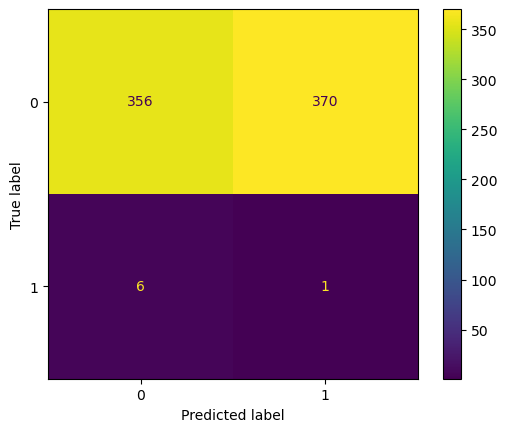

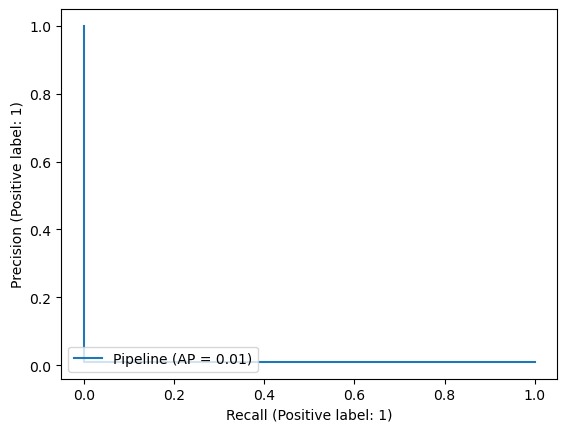

In [37]:
# baseline accuracy -> dummy classifier predicting class at random
pipeline = Pipeline([
    ('custom_preprocessor', CustomPreprocessor()),
    ('classifier', DummyClassifier(strategy="uniform"))
])
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.1, random_state=42)
pipeline.fit(X_train, y_train)
y_pred_dummy = pipeline.predict(X_test)
precision = f1_score(y_test, y_pred_dummy)
print(precision)
cm = confusion_matrix(y_test, y_pred_dummy)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()

PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.1, random_state=42)

In [39]:
counter = Counter(y_train)
print(counter)

Counter({0: 6537, 1: 55})


In [45]:
def run_experiment(features, param_distributions, pipeline,
                   n_splits=4, n_iter=40, 
                   classifier=None, plot_param_charts=True):

    cv = StratifiedKFold(n_splits=n_splits)
    scoring = {
        "precision": make_scorer(precision_score)
    }
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=n_iter,  # Number of random combinations to try
        scoring=scoring,  # Choose your preferred metric
        cv=cv,  # StratifiedKFold cross-validation
        verbose=10,  # Print out progress
        n_jobs=1,  # Use all available cores
        random_state=42,  # Reproducibility
        refit="precision",
        return_train_score=True
    )
    random_search.fit(X_train, y_train)
    print(random_search.best_score_, random_search.best_params_)

    clf = random_search.best_estimator_
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    print(precision_score(y_test, y_pred))
    PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
    plt.show()

    # for each parameter, plot line graphs of the train auc score, test auc score, and train - test score (to identify overfitting)
    if plot_param_charts:
        cv_results_df = pd.DataFrame(random_search.cv_results_)
        params = list(cv_results_df.params[0].keys())
        cv_results_df['train_test_diff_precision'] = cv_results_df['mean_train_precision'] - cv_results_df['mean_test_precision']

        num_cols = 3
        num_rows = (3*len(param_distributions) + num_cols - 1) // num_cols
        fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(15, 4*num_rows))
        ax = ax.flatten()

        for i, param in enumerate(params):
            sns.lineplot(cv_results_df, x='param_' + param, y='mean_test_precision', label='Test precision', ax=ax[i*3+0])
            sns.lineplot(cv_results_df, x='param_' + param, y='mean_train_precision', label='Train precision', ax=ax[i*3+1])
            sns.lineplot(cv_results_df, x='param_' + param, y='train_test_diff_precision', label='Train-Test precision Difference', ax=ax[i*3+2])

        plt.legend()
        plt.show()
    
    return random_search

### XGBoost

a. balanced sampling

In [41]:
counter = Counter(df[target])
scale_pos_weight = counter[0] / counter[1]
scale_pos_weight

117.14516129032258

0.0


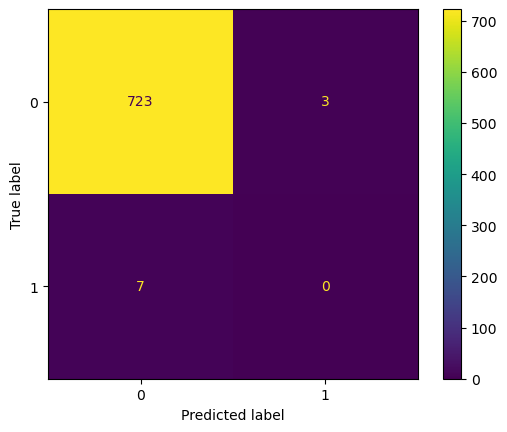

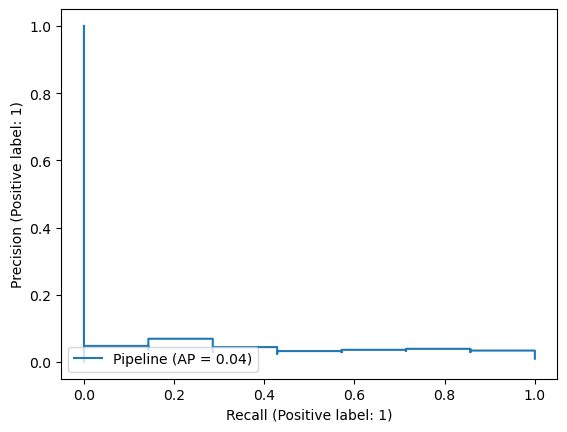

In [42]:
classifier = XGBClassifier(n_jobs=None, scale_pos_weight=scale_pos_weight, eval_metric='aucpr')
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('classifier', classifier)
    ])
eval_set = [(X_train, y_train), (X_test, y_test)]
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
print(precision_score(y_test, y_pred))
PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

b. SMOTE

0.0


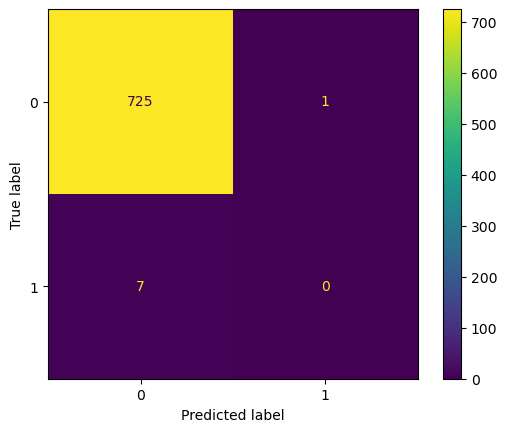

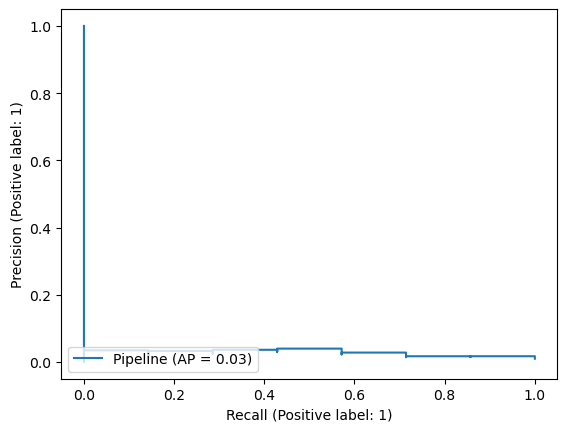

In [43]:
classifier = XGBClassifier(n_jobs=None, eval_metric='aucpr')
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('over', SMOTE(sampling_strategy='not majority')),        
        ('classifier', classifier)
    ])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
print(precision_score(y_test, y_pred))
PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

balanced sampling works better than SMOTE

hyperparameter tuning

1. max_depth and min_child_weight

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV 1/4; 1/50] START classifier__max_depth=755, classifier__min_child_weight=20.689655172413794
[CV 1/4; 1/50] END classifier__max_depth=755, classifier__min_child_weight=20.689655172413794; precision: (train=0.545, test=0.094) total time=   0.5s
[CV 2/4; 1/50] START classifier__max_depth=755, classifier__min_child_weight=20.689655172413794
[CV 2/4; 1/50] END classifier__max_depth=755, classifier__min_child_weight=20.689655172413794; precision: (train=0.547, test=0.160) total time=   0.4s
[CV 3/4; 1/50] START classifier__max_depth=755, classifier__min_child_weight=20.689655172413794
[CV 3/4; 1/50] END classifier__max_depth=755, classifier__min_child_weight=20.689655172413794; precision: (train=0.569, test=0.105) total time=   0.4s
[CV 4/4; 1/50] START classifier__max_depth=755, classifier__min_child_weight=20.689655172413794
[CV 4/4; 1/50] END classifier__max_depth=755, classifier__min_child_weight=20.689655172413794; precis

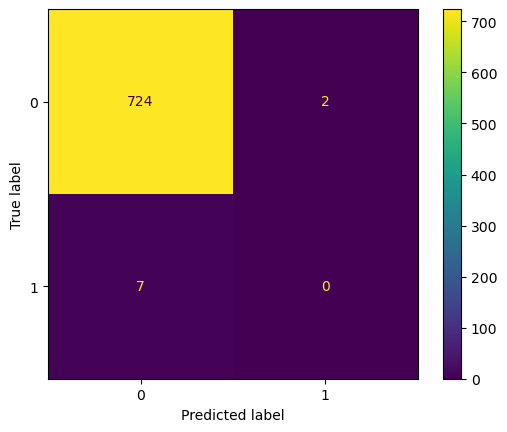

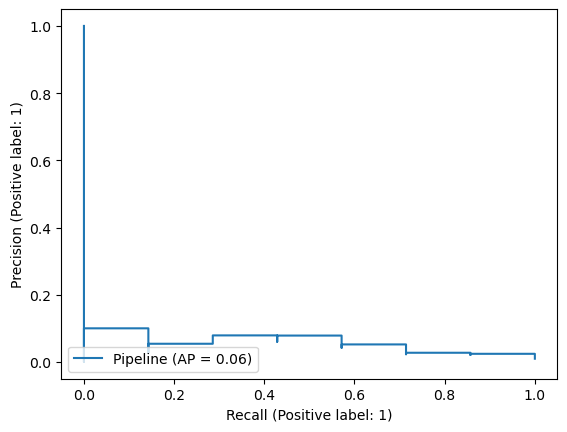

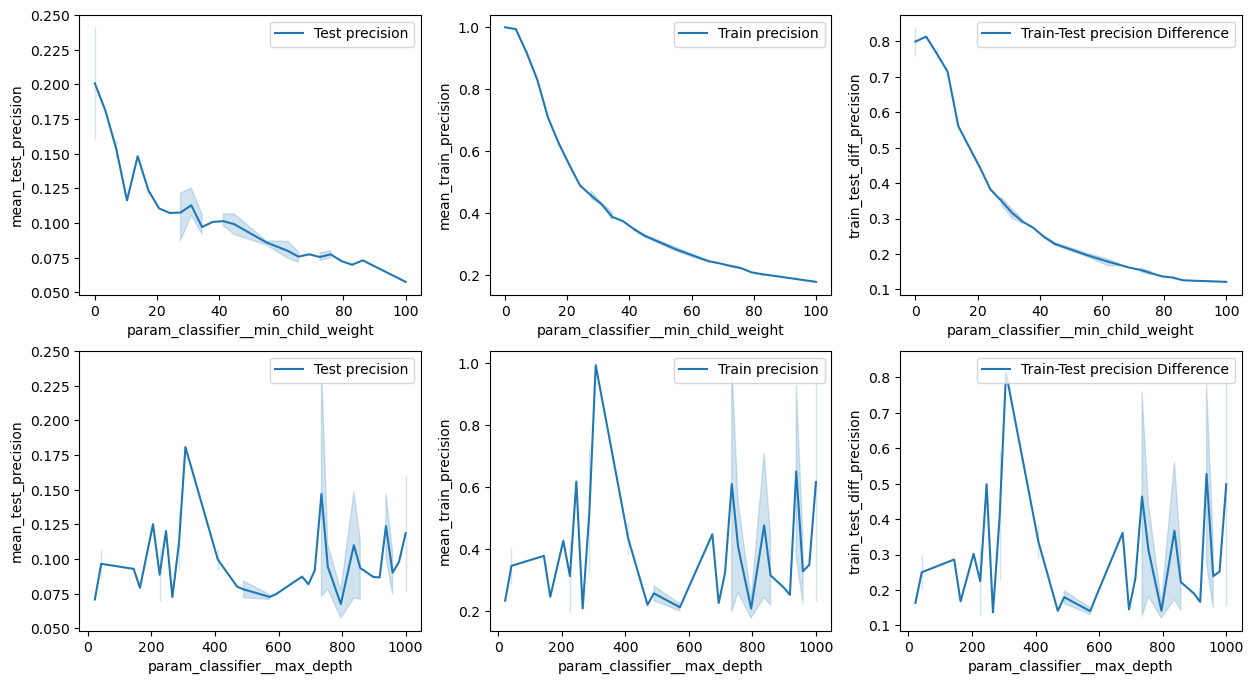

In [64]:
param_distributions = {
        "classifier__max_depth": [np.int64(i) for i in np.linspace(2, 1000, 50)],
        "classifier__min_child_weight": [i for i in np.linspace(0, 100, 30)]
    }
classifier = XGBClassifier(n_jobs=None, scale_pos_weight=scale_pos_weight, eval_metric='aucpr')
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('over', SMOTE(sampling_strategy='not majority')),
        ('classifier', classifier)
    ])
random_search = run_experiment(features, param_distributions, pipeline, 
                               n_iter=50, n_splits=4, 
                               classifier=classifier)

2. subsample and colsample_bytree

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV 1/4; 1/50] START classifier__colsample_bytree=0.1...........................
[CV 1/4; 1/50] END classifier__colsample_bytree=0.1; precision: (train=0.840, test=0.143) total time=   0.3s
[CV 2/4; 1/50] START classifier__colsample_bytree=0.1...........................
[CV 2/4; 1/50] END classifier__colsample_bytree=0.1; precision: (train=0.911, test=0.333) total time=   0.3s
[CV 3/4; 1/50] START classifier__colsample_bytree=0.1...........................
[CV 3/4; 1/50] END classifier__colsample_bytree=0.1; precision: (train=0.804, test=0.000) total time=   0.3s
[CV 4/4; 1/50] START classifier__colsample_bytree=0.1...........................
[CV 4/4; 1/50] END classifier__colsample_bytree=0.1; precision: (train=0.804, test=0.000) total time=   0.3s
[CV 1/4; 2/50] START classifier__colsample_bytree=0.11836734693877551...........
[CV 1/4; 2/50] END classifier__colsample_bytree=0.11836734693877551; precision: (train=0.840, tes

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 7/50] END classifier__colsample_bytree=0.21020408163265308; precision: (train=1.000, test=0.000) total time=   0.3s
[CV 1/4; 8/50] START classifier__colsample_bytree=0.2285714285714286............
[CV 1/4; 8/50] END classifier__colsample_bytree=0.2285714285714286; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 2/4; 8/50] START classifier__colsample_bytree=0.2285714285714286............
[CV 2/4; 8/50] END classifier__colsample_bytree=0.2285714285714286; precision: (train=1.000, test=0.500) total time=   0.3s
[CV 3/4; 8/50] START classifier__colsample_bytree=0.2285714285714286............
[CV 3/4; 8/50] END classifier__colsample_bytree=0.2285714285714286; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 4/4; 8/50] START classifier__colsample_bytree=0.2285714285714286............


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 8/50] END classifier__colsample_bytree=0.2285714285714286; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 1/4; 9/50] START classifier__colsample_bytree=0.2469387755102041............
[CV 1/4; 9/50] END classifier__colsample_bytree=0.2469387755102041; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 2/4; 9/50] START classifier__colsample_bytree=0.2469387755102041............
[CV 2/4; 9/50] END classifier__colsample_bytree=0.2469387755102041; precision: (train=1.000, test=0.333) total time=   0.4s
[CV 3/4; 9/50] START classifier__colsample_bytree=0.2469387755102041............
[CV 3/4; 9/50] END classifier__colsample_bytree=0.2469387755102041; precision: (train=1.000, test=0.000) total time=   0.5s
[CV 4/4; 9/50] START classifier__colsample_bytree=0.2469387755102041............
[CV 4/4; 9/50] END classifier__colsample_bytree=0.2469387755102041; precision: (train=1.000, test=0.000) total time=   0.5s
[CV 1/4; 10/50] START classifier__colsample_bytree=0.265

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 11/50] END classifier__colsample_bytree=0.2836734693877551; precision: (train=1.000, test=0.000) total time=   0.5s
[CV 1/4; 12/50] START classifier__colsample_bytree=0.3020408163265306...........
[CV 1/4; 12/50] END classifier__colsample_bytree=0.3020408163265306; precision: (train=1.000, test=0.000) total time=   0.6s
[CV 2/4; 12/50] START classifier__colsample_bytree=0.3020408163265306...........
[CV 2/4; 12/50] END classifier__colsample_bytree=0.3020408163265306; precision: (train=1.000, test=0.500) total time=   0.5s
[CV 3/4; 12/50] START classifier__colsample_bytree=0.3020408163265306...........
[CV 3/4; 12/50] END classifier__colsample_bytree=0.3020408163265306; precision: (train=1.000, test=0.000) total time=   0.7s
[CV 4/4; 12/50] START classifier__colsample_bytree=0.3020408163265306...........


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 12/50] END classifier__colsample_bytree=0.3020408163265306; precision: (train=1.000, test=0.000) total time=   0.6s
[CV 1/4; 13/50] START classifier__colsample_bytree=0.3204081632653062...........
[CV 1/4; 13/50] END classifier__colsample_bytree=0.3204081632653062; precision: (train=1.000, test=0.000) total time=   0.5s
[CV 2/4; 13/50] START classifier__colsample_bytree=0.3204081632653062...........
[CV 2/4; 13/50] END classifier__colsample_bytree=0.3204081632653062; precision: (train=1.000, test=0.000) total time=   0.7s
[CV 3/4; 13/50] START classifier__colsample_bytree=0.3204081632653062...........
[CV 3/4; 13/50] END classifier__colsample_bytree=0.3204081632653062; precision: (train=1.000, test=0.500) total time=   0.7s
[CV 4/4; 13/50] START classifier__colsample_bytree=0.3204081632653062...........


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 13/50] END classifier__colsample_bytree=0.3204081632653062; precision: (train=1.000, test=0.000) total time=   0.5s
[CV 1/4; 14/50] START classifier__colsample_bytree=0.3387755102040817...........
[CV 1/4; 14/50] END classifier__colsample_bytree=0.3387755102040817; precision: (train=1.000, test=0.000) total time=   0.7s
[CV 2/4; 14/50] START classifier__colsample_bytree=0.3387755102040817...........
[CV 2/4; 14/50] END classifier__colsample_bytree=0.3387755102040817; precision: (train=1.000, test=0.000) total time=   0.9s
[CV 3/4; 14/50] START classifier__colsample_bytree=0.3387755102040817...........
[CV 3/4; 14/50] END classifier__colsample_bytree=0.3387755102040817; precision: (train=1.000, test=0.500) total time=   0.6s
[CV 4/4; 14/50] START classifier__colsample_bytree=0.3387755102040817...........


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 14/50] END classifier__colsample_bytree=0.3387755102040817; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 1/4; 15/50] START classifier__colsample_bytree=0.3571428571428572...........
[CV 1/4; 15/50] END classifier__colsample_bytree=0.3571428571428572; precision: (train=1.000, test=0.000) total time=   0.5s
[CV 2/4; 15/50] START classifier__colsample_bytree=0.3571428571428572...........
[CV 2/4; 15/50] END classifier__colsample_bytree=0.3571428571428572; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 3/4; 15/50] START classifier__colsample_bytree=0.3571428571428572...........
[CV 3/4; 15/50] END classifier__colsample_bytree=0.3571428571428572; precision: (train=1.000, test=0.500) total time=   0.4s
[CV 4/4; 15/50] START classifier__colsample_bytree=0.3571428571428572...........


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 15/50] END classifier__colsample_bytree=0.3571428571428572; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 1/4; 16/50] START classifier__colsample_bytree=0.3755102040816327...........
[CV 1/4; 16/50] END classifier__colsample_bytree=0.3755102040816327; precision: (train=1.000, test=0.000) total time=   0.5s
[CV 2/4; 16/50] START classifier__colsample_bytree=0.3755102040816327...........
[CV 2/4; 16/50] END classifier__colsample_bytree=0.3755102040816327; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 3/4; 16/50] START classifier__colsample_bytree=0.3755102040816327...........
[CV 3/4; 16/50] END classifier__colsample_bytree=0.3755102040816327; precision: (train=1.000, test=0.500) total time=   0.5s
[CV 4/4; 16/50] START classifier__colsample_bytree=0.3755102040816327...........


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 16/50] END classifier__colsample_bytree=0.3755102040816327; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 1/4; 17/50] START classifier__colsample_bytree=0.3938775510204082...........
[CV 1/4; 17/50] END classifier__colsample_bytree=0.3938775510204082; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 2/4; 17/50] START classifier__colsample_bytree=0.3938775510204082...........
[CV 2/4; 17/50] END classifier__colsample_bytree=0.3938775510204082; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 3/4; 17/50] START classifier__colsample_bytree=0.3938775510204082...........
[CV 3/4; 17/50] END classifier__colsample_bytree=0.3938775510204082; precision: (train=1.000, test=0.500) total time=   0.6s
[CV 4/4; 17/50] START classifier__colsample_bytree=0.3938775510204082...........


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 17/50] END classifier__colsample_bytree=0.3938775510204082; precision: (train=1.000, test=0.000) total time=   0.6s
[CV 1/4; 18/50] START classifier__colsample_bytree=0.41224489795918373..........
[CV 1/4; 18/50] END classifier__colsample_bytree=0.41224489795918373; precision: (train=1.000, test=0.000) total time=   0.6s
[CV 2/4; 18/50] START classifier__colsample_bytree=0.41224489795918373..........
[CV 2/4; 18/50] END classifier__colsample_bytree=0.41224489795918373; precision: (train=1.000, test=0.333) total time=   0.5s
[CV 3/4; 18/50] START classifier__colsample_bytree=0.41224489795918373..........
[CV 3/4; 18/50] END classifier__colsample_bytree=0.41224489795918373; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 4/4; 18/50] START classifier__colsample_bytree=0.41224489795918373..........


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 18/50] END classifier__colsample_bytree=0.41224489795918373; precision: (train=1.000, test=0.000) total time=   0.4s
[CV 1/4; 19/50] START classifier__colsample_bytree=0.43061224489795924..........
[CV 1/4; 19/50] END classifier__colsample_bytree=0.43061224489795924; precision: (train=1.000, test=0.000) total time=   0.5s
[CV 2/4; 19/50] START classifier__colsample_bytree=0.43061224489795924..........
[CV 2/4; 19/50] END classifier__colsample_bytree=0.43061224489795924; precision: (train=1.000, test=0.333) total time=   0.6s
[CV 3/4; 19/50] START classifier__colsample_bytree=0.43061224489795924..........
[CV 3/4; 19/50] END classifier__colsample_bytree=0.43061224489795924; precision: (train=1.000, test=0.000) total time=   0.6s
[CV 4/4; 19/50] START classifier__colsample_bytree=0.43061224489795924..........


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 19/50] END classifier__colsample_bytree=0.43061224489795924; precision: (train=1.000, test=0.000) total time=   0.5s
[CV 1/4; 20/50] START classifier__colsample_bytree=0.44897959183673475..........
[CV 1/4; 20/50] END classifier__colsample_bytree=0.44897959183673475; precision: (train=1.000, test=0.000) total time=   0.5s
[CV 2/4; 20/50] START classifier__colsample_bytree=0.44897959183673475..........
[CV 2/4; 20/50] END classifier__colsample_bytree=0.44897959183673475; precision: (train=1.000, test=0.333) total time=   0.6s
[CV 3/4; 20/50] START classifier__colsample_bytree=0.44897959183673475..........
[CV 3/4; 20/50] END classifier__colsample_bytree=0.44897959183673475; precision: (train=1.000, test=0.000) total time=   0.6s
[CV 4/4; 20/50] START classifier__colsample_bytree=0.44897959183673475..........
[CV 4/4; 20/50] END classifier__colsample_bytree=0.44897959183673475; precision: (train=1.000, test=0.000) total time=   0.5s
[CV 1/4; 21/50] START classifier__colsample_by

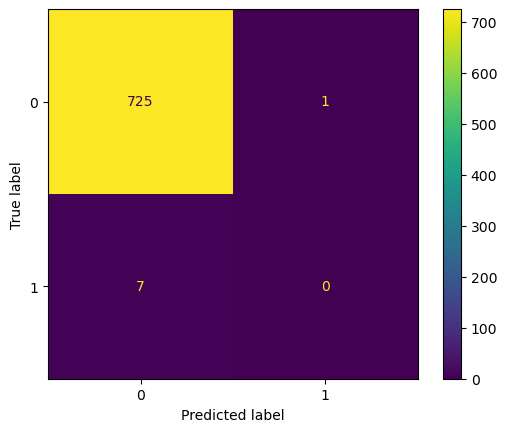

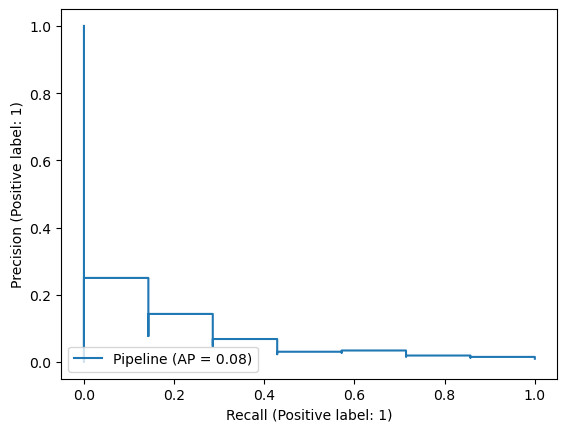

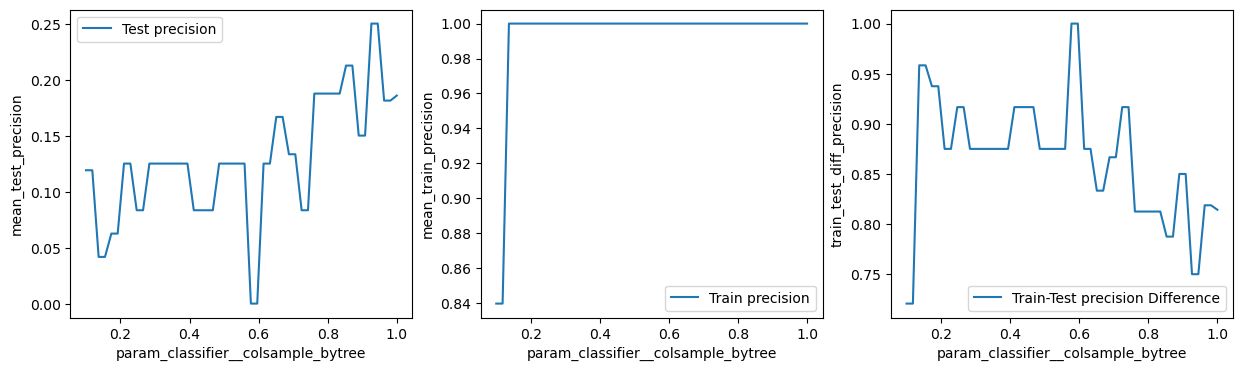

In [66]:
max_depth, min_child_weight = 735, 0.0

param_distributions = {
        "classifier__colsample_bytree": [i for i in np.linspace(0.1, 1, 50)]
        #,"classifier__subsample": [i for i in np.linspace(0.1, 1, 20)]
    }
classifier = XGBClassifier(n_jobs=None, scale_pos_weight=scale_pos_weight, eval_metric='aucpr', max_depth=max_depth, min_child_weight=min_child_weight)
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('classifier', classifier)
    ])
random_search = run_experiment(features, param_distributions, pipeline, 
                               n_iter=50, n_splits=4, 
                               classifier=classifier)

3. eta

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV 1/4; 1/50] START classifier__eta=0.01.......................................
[CV 1/4; 1/50] END classifier__eta=0.01; precision: (train=0.677, test=0.188) total time=   0.4s
[CV 2/4; 1/50] START classifier__eta=0.01.......................................
[CV 2/4; 1/50] END classifier__eta=0.01; precision: (train=0.603, test=0.111) total time=   0.4s
[CV 3/4; 1/50] START classifier__eta=0.01.......................................
[CV 3/4; 1/50] END classifier__eta=0.01; precision: (train=0.519, test=0.100) total time=   0.4s
[CV 4/4; 1/50] START classifier__eta=0.01.......................................
[CV 4/4; 1/50] END classifier__eta=0.01; precision: (train=0.554, test=0.095) total time=   0.4s
[CV 1/4; 2/50] START classifier__eta=0.017959183673469388.......................
[CV 1/4; 2/50] END classifier__eta=0.017959183673469388; precision: (train=0.737, test=0.133) total time=   0.4s
[CV 2/4; 2/50] START classifier_

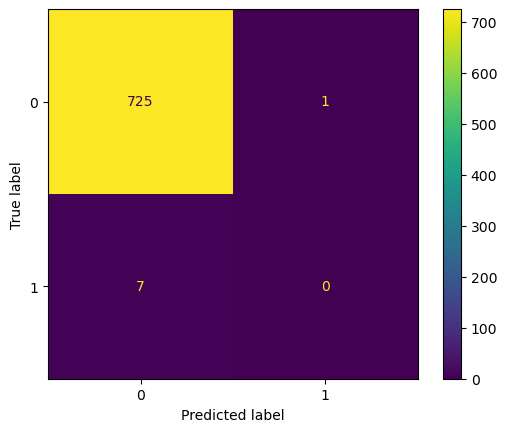

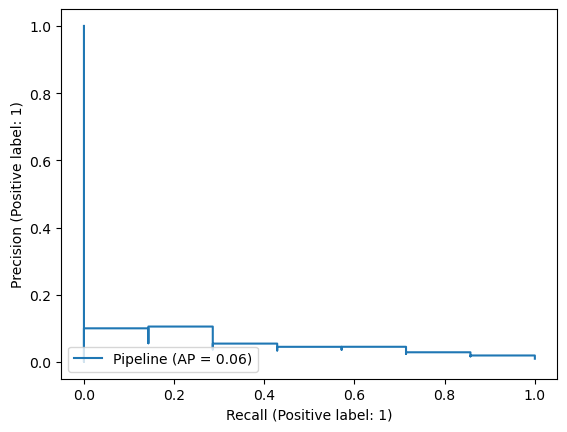

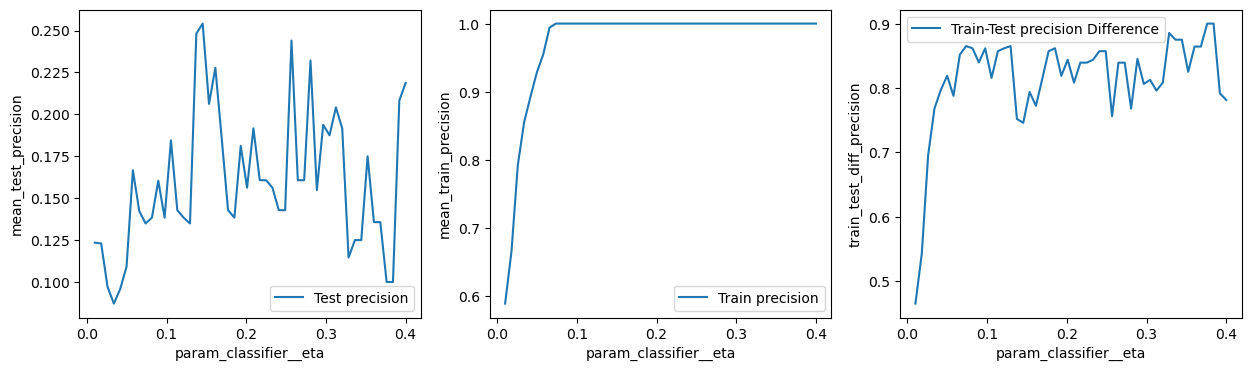

In [69]:
colsample_bytree = 0.926530612244898

param_distributions = {
        "classifier__eta": [i for i in np.linspace(0.01, 0.4, 50)]
    }
classifier = XGBClassifier(n_jobs=None, scale_pos_weight=scale_pos_weight, eval_metric='aucpr'
                           , max_depth=max_depth, min_child_weight=min_child_weight
                           , colsample_bytree=colsample_bytree)
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('classifier', classifier)
    ])
random_search = run_experiment(features, param_distributions, pipeline, 
                               n_iter=50, n_splits=4, 
                               classifier=classifier)

4. final model

0.0


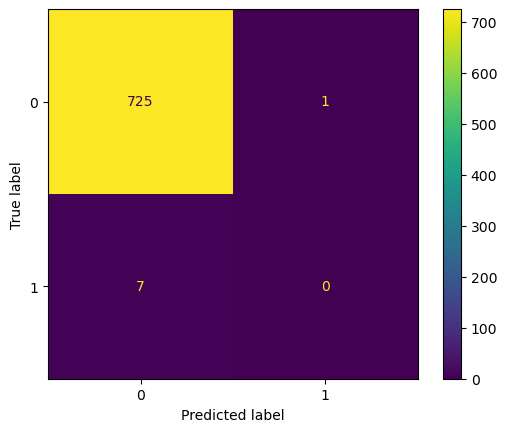

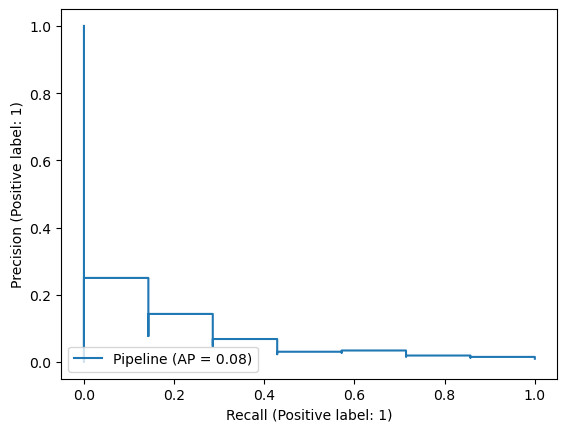

In [96]:
eta = 0.3

classifier = XGBClassifier(n_jobs=None, scale_pos_weight=scale_pos_weight, eval_metric='aucpr'
                           , max_depth=max_depth, min_child_weight=min_child_weight
                           , colsample_bytree=colsample_bytree
                           , eta=eta)
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('classifier', classifier)
    ])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
print(precision_score(y_test, y_pred))

PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

0.25


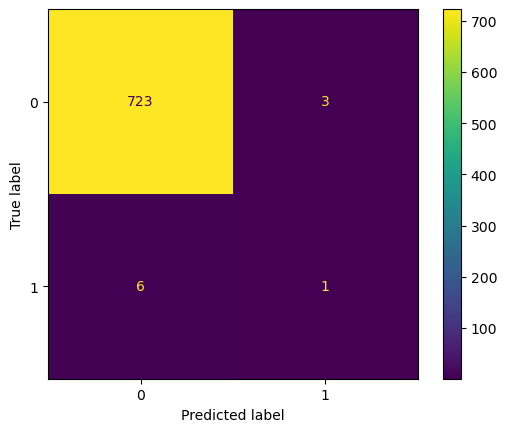

In [97]:
threshold = 0.03
y_pred = pipeline.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred > threshold, 1, 0)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
print(precision_score(y_test, y_pred))

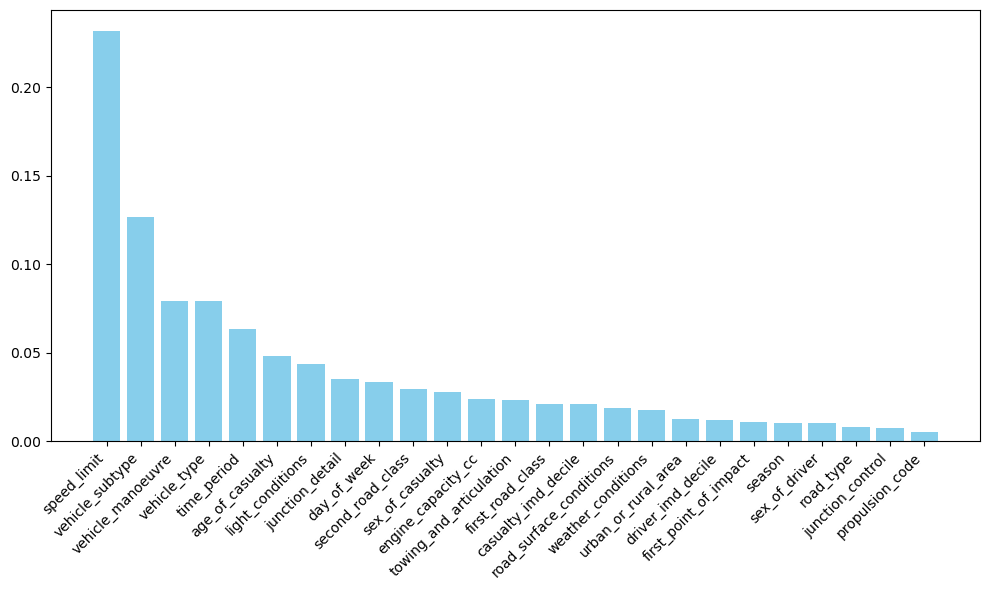

In [98]:
features = pipeline.named_steps["custom_preprocessor"].get_feature_names_out()
importances = pipeline.named_steps["classifier"].feature_importances_
feature_importances = sorted(
    [i for i in zip(features, importances)], 
    key=lambda x: x[1],
    reverse=True
)
feature_importances = feature_importances
labels, values = zip(*feature_importances)

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

### Random Forest

a. balanced sampling

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0


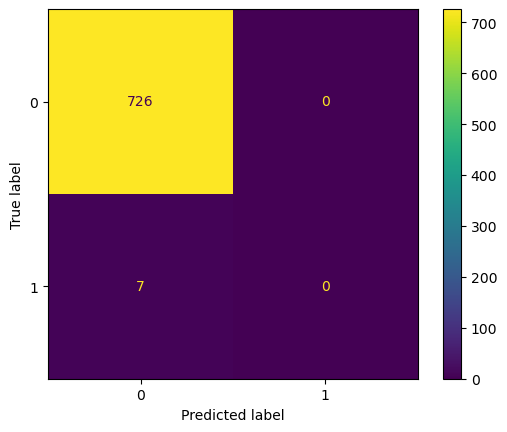

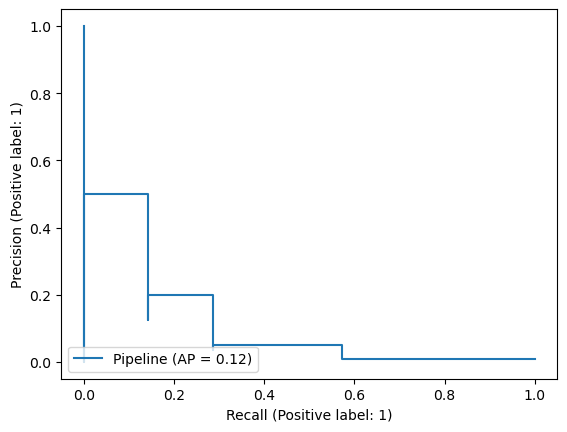

In [55]:
classifier = RandomForestClassifier(class_weight='balanced')
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('classifier', classifier)
    ])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
print(precision_score(y_test, y_pred))
PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

b. SMOTE

0.0


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


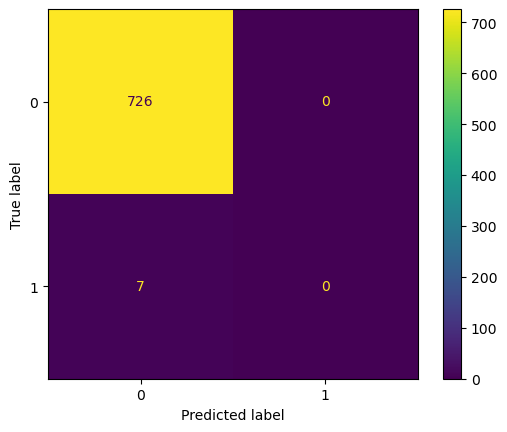

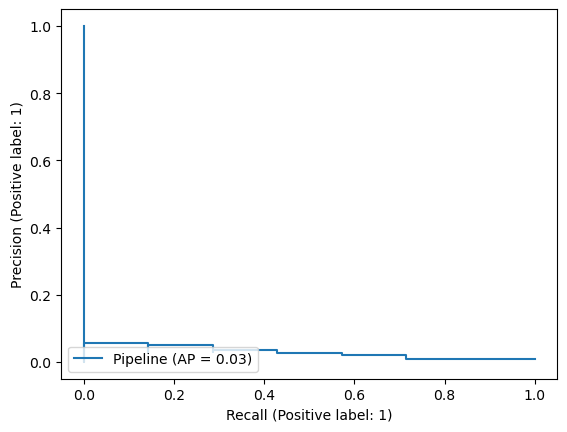

In [56]:
classifier = RandomForestClassifier()
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('over', SMOTE(sampling_strategy='not majority')),
        ('classifier', classifier)
    ])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
print(precision_score(y_test, y_pred))
PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

balanced sampling works better than SMOTE

hyperparameter tuning

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV 1/4; 1/100] START classifier__max_depth=221, classifier__max_features=0.775, classifier__max_leaf_nodes=None, classifier__min_samples_split=6, classifier__n_estimators=750
[CV 1/4; 1/100] END classifier__max_depth=221, classifier__max_features=0.775, classifier__max_leaf_nodes=None, classifier__min_samples_split=6, classifier__n_estimators=750; precision: (train=0.977, test=0.000) total time=   6.4s
[CV 2/4; 1/100] START classifier__max_depth=221, classifier__max_features=0.775, classifier__max_leaf_nodes=None, classifier__min_samples_split=6, classifier__n_estimators=750
[CV 2/4; 1/100] END classifier__max_depth=221, classifier__max_features=0.775, classifier__max_leaf_nodes=None, classifier__min_samples_split=6, classifier__n_estimators=750; precision: (train=0.976, test=0.000) total time=   6.0s
[CV 3/4; 1/100] START classifier__max_depth=221, classifier__max_features=0.775, classifier__max_leaf_nodes=None, classifie

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 1/100] END classifier__max_depth=221, classifier__max_features=0.775, classifier__max_leaf_nodes=None, classifier__min_samples_split=6, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   6.7s
[CV 1/4; 2/100] START classifier__max_depth=266, classifier__max_features=1.0, classifier__max_leaf_nodes=100, classifier__min_samples_split=12, classifier__n_estimators=750
[CV 1/4; 2/100] END classifier__max_depth=266, classifier__max_features=1.0, classifier__max_leaf_nodes=100, classifier__min_samples_split=12, classifier__n_estimators=750; precision: (train=0.955, test=0.000) total time=   9.4s
[CV 2/4; 2/100] START classifier__max_depth=266, classifier__max_features=1.0, classifier__max_leaf_nodes=100, classifier__min_samples_split=12, classifier__n_estimators=750
[CV 2/4; 2/100] END classifier__max_depth=266, classifier__max_features=1.0, classifier__max_leaf_nodes=100, classifier__min_samples_split=12, classifier__n_estimators=750; precision: (train=0

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 2/100] END classifier__max_depth=266, classifier__max_features=1.0, classifier__max_leaf_nodes=100, classifier__min_samples_split=12, classifier__n_estimators=750; precision: (train=0.891, test=0.000) total time=   6.6s
[CV 1/4; 3/100] START classifier__max_depth=236, classifier__max_features=1.0, classifier__max_leaf_nodes=None, classifier__min_samples_split=56, classifier__n_estimators=250
[CV 1/4; 3/100] END classifier__max_depth=236, classifier__max_features=1.0, classifier__max_leaf_nodes=None, classifier__min_samples_split=56, classifier__n_estimators=250; precision: (train=0.506, test=0.190) total time=   2.4s
[CV 2/4; 3/100] START classifier__max_depth=236, classifier__max_features=1.0, classifier__max_leaf_nodes=None, classifier__min_samples_split=56, classifier__n_estimators=250
[CV 2/4; 3/100] END classifier__max_depth=236, classifier__max_features=1.0, classifier__max_leaf_nodes=None, classifier__min_samples_split=56, classifier__n_estimators=250; precision: (train

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 7/100] END classifier__max_depth=206, classifier__max_features=0.325, classifier__max_leaf_nodes=1000, classifier__min_samples_split=14, classifier__n_estimators=100; precision: (train=0.872, test=0.000) total time=   0.5s
[CV 1/4; 8/100] START classifier__max_depth=387, classifier__max_features=0.1, classifier__max_leaf_nodes=None, classifier__min_samples_split=96, classifier__n_estimators=250
[CV 1/4; 8/100] END classifier__max_depth=387, classifier__max_features=0.1, classifier__max_leaf_nodes=None, classifier__min_samples_split=96, classifier__n_estimators=250; precision: (train=0.315, test=0.111) total time=   0.8s
[CV 2/4; 8/100] START classifier__max_depth=387, classifier__max_features=0.1, classifier__max_leaf_nodes=None, classifier__min_samples_split=96, classifier__n_estimators=250
[CV 2/4; 8/100] END classifier__max_depth=387, classifier__max_features=0.1, classifier__max_leaf_nodes=None, classifier__min_samples_split=96, classifier__n_estimators=250; precision: (tr

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/4; 14/100] END classifier__max_depth=327, classifier__max_features=0.325, classifier__max_leaf_nodes=300, classifier__min_samples_split=4, classifier__n_estimators=100; precision: (train=1.000, test=0.000) total time=   0.8s
[CV 3/4; 14/100] START classifier__max_depth=327, classifier__max_features=0.325, classifier__max_leaf_nodes=300, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 3/4; 14/100] END classifier__max_depth=327, classifier__max_features=0.325, classifier__max_leaf_nodes=300, classifier__min_samples_split=4, classifier__n_estimators=100; precision: (train=1.000, test=0.000) total time=   1.0s
[CV 4/4; 14/100] START classifier__max_depth=327, classifier__max_features=0.325, classifier__max_leaf_nodes=300, classifier__min_samples_split=4, classifier__n_estimators=100


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 14/100] END classifier__max_depth=327, classifier__max_features=0.325, classifier__max_leaf_nodes=300, classifier__min_samples_split=4, classifier__n_estimators=100; precision: (train=1.000, test=0.000) total time=   0.8s
[CV 1/4; 15/100] START classifier__max_depth=357, classifier__max_features=0.1, classifier__max_leaf_nodes=None, classifier__min_samples_split=58, classifier__n_estimators=250
[CV 1/4; 15/100] END classifier__max_depth=357, classifier__max_features=0.1, classifier__max_leaf_nodes=None, classifier__min_samples_split=58, classifier__n_estimators=250; precision: (train=0.506, test=0.143) total time=   1.0s
[CV 2/4; 15/100] START classifier__max_depth=357, classifier__max_features=0.1, classifier__max_leaf_nodes=None, classifier__min_samples_split=58, classifier__n_estimators=250
[CV 2/4; 15/100] END classifier__max_depth=357, classifier__max_features=0.1, classifier__max_leaf_nodes=None, classifier__min_samples_split=58, classifier__n_estimators=250; precision: 

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/4; 26/100] END classifier__max_depth=493, classifier__max_features=0.55, classifier__max_leaf_nodes=200, classifier__min_samples_split=4, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   4.4s
[CV 3/4; 26/100] START classifier__max_depth=493, classifier__max_features=0.55, classifier__max_leaf_nodes=200, classifier__min_samples_split=4, classifier__n_estimators=750
[CV 3/4; 26/100] END classifier__max_depth=493, classifier__max_features=0.55, classifier__max_leaf_nodes=200, classifier__min_samples_split=4, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   4.7s
[CV 4/4; 26/100] START classifier__max_depth=493, classifier__max_features=0.55, classifier__max_leaf_nodes=200, classifier__min_samples_split=4, classifier__n_estimators=750


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 26/100] END classifier__max_depth=493, classifier__max_features=0.55, classifier__max_leaf_nodes=200, classifier__min_samples_split=4, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   4.5s
[CV 1/4; 27/100] START classifier__max_depth=191, classifier__max_features=0.55, classifier__max_leaf_nodes=800, classifier__min_samples_split=4, classifier__n_estimators=750
[CV 1/4; 27/100] END classifier__max_depth=191, classifier__max_features=0.55, classifier__max_leaf_nodes=800, classifier__min_samples_split=4, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   5.0s
[CV 2/4; 27/100] START classifier__max_depth=191, classifier__max_features=0.55, classifier__max_leaf_nodes=800, classifier__min_samples_split=4, classifier__n_estimators=750


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/4; 27/100] END classifier__max_depth=191, classifier__max_features=0.55, classifier__max_leaf_nodes=800, classifier__min_samples_split=4, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   4.5s
[CV 3/4; 27/100] START classifier__max_depth=191, classifier__max_features=0.55, classifier__max_leaf_nodes=800, classifier__min_samples_split=4, classifier__n_estimators=750
[CV 3/4; 27/100] END classifier__max_depth=191, classifier__max_features=0.55, classifier__max_leaf_nodes=800, classifier__min_samples_split=4, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   4.8s
[CV 4/4; 27/100] START classifier__max_depth=191, classifier__max_features=0.55, classifier__max_leaf_nodes=800, classifier__min_samples_split=4, classifier__n_estimators=750


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 27/100] END classifier__max_depth=191, classifier__max_features=0.55, classifier__max_leaf_nodes=800, classifier__min_samples_split=4, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   4.5s
[CV 1/4; 28/100] START classifier__max_depth=432, classifier__max_features=0.55, classifier__max_leaf_nodes=1000, classifier__min_samples_split=98, classifier__n_estimators=750
[CV 1/4; 28/100] END classifier__max_depth=432, classifier__max_features=0.55, classifier__max_leaf_nodes=1000, classifier__min_samples_split=98, classifier__n_estimators=750; precision: (train=0.328, test=0.150) total time=   4.1s
[CV 2/4; 28/100] START classifier__max_depth=432, classifier__max_features=0.55, classifier__max_leaf_nodes=1000, classifier__min_samples_split=98, classifier__n_estimators=750
[CV 2/4; 28/100] END classifier__max_depth=432, classifier__max_features=0.55, classifier__max_leaf_nodes=1000, classifier__min_samples_split=98, classifier__n_estimators=750; precisio

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 62/100] END classifier__max_depth=387, classifier__max_features=0.1, classifier__max_leaf_nodes=1000, classifier__min_samples_split=18, classifier__n_estimators=100; precision: (train=0.891, test=0.000) total time=   0.4s
[CV 1/4; 63/100] START classifier__max_depth=None, classifier__max_features=0.55, classifier__max_leaf_nodes=900, classifier__min_samples_split=76, classifier__n_estimators=750
[CV 1/4; 63/100] END classifier__max_depth=None, classifier__max_features=0.55, classifier__max_leaf_nodes=900, classifier__min_samples_split=76, classifier__n_estimators=750; precision: (train=0.408, test=0.138) total time=   4.2s
[CV 2/4; 63/100] START classifier__max_depth=None, classifier__max_features=0.55, classifier__max_leaf_nodes=900, classifier__min_samples_split=76, classifier__n_estimators=750
[CV 2/4; 63/100] END classifier__max_depth=None, classifier__max_features=0.55, classifier__max_leaf_nodes=900, classifier__min_samples_split=76, classifier__n_estimators=750; precisi

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 1/4; 72/100] END classifier__max_depth=478, classifier__max_features=0.1, classifier__max_leaf_nodes=600, classifier__min_samples_split=6, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   2.4s
[CV 2/4; 72/100] START classifier__max_depth=478, classifier__max_features=0.1, classifier__max_leaf_nodes=600, classifier__min_samples_split=6, classifier__n_estimators=750
[CV 2/4; 72/100] END classifier__max_depth=478, classifier__max_features=0.1, classifier__max_leaf_nodes=600, classifier__min_samples_split=6, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   2.7s
[CV 3/4; 72/100] START classifier__max_depth=478, classifier__max_features=0.1, classifier__max_leaf_nodes=600, classifier__min_samples_split=6, classifier__n_estimators=750


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/4; 72/100] END classifier__max_depth=478, classifier__max_features=0.1, classifier__max_leaf_nodes=600, classifier__min_samples_split=6, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   2.3s
[CV 4/4; 72/100] START classifier__max_depth=478, classifier__max_features=0.1, classifier__max_leaf_nodes=600, classifier__min_samples_split=6, classifier__n_estimators=750


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 72/100] END classifier__max_depth=478, classifier__max_features=0.1, classifier__max_leaf_nodes=600, classifier__min_samples_split=6, classifier__n_estimators=750; precision: (train=1.000, test=0.000) total time=   2.3s
[CV 1/4; 73/100] START classifier__max_depth=508, classifier__max_features=1.0, classifier__max_leaf_nodes=400, classifier__min_samples_split=4, classifier__n_estimators=100
[CV 1/4; 73/100] END classifier__max_depth=508, classifier__max_features=1.0, classifier__max_leaf_nodes=400, classifier__min_samples_split=4, classifier__n_estimators=100; precision: (train=1.000, test=0.000) total time=   1.2s
[CV 2/4; 73/100] START classifier__max_depth=508, classifier__max_features=1.0, classifier__max_leaf_nodes=400, classifier__min_samples_split=4, classifier__n_estimators=100


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/4; 73/100] END classifier__max_depth=508, classifier__max_features=1.0, classifier__max_leaf_nodes=400, classifier__min_samples_split=4, classifier__n_estimators=100; precision: (train=1.000, test=0.000) total time=   1.1s
[CV 3/4; 73/100] START classifier__max_depth=508, classifier__max_features=1.0, classifier__max_leaf_nodes=400, classifier__min_samples_split=4, classifier__n_estimators=100


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/4; 73/100] END classifier__max_depth=508, classifier__max_features=1.0, classifier__max_leaf_nodes=400, classifier__min_samples_split=4, classifier__n_estimators=100; precision: (train=1.000, test=0.000) total time=   1.3s
[CV 4/4; 73/100] START classifier__max_depth=508, classifier__max_features=1.0, classifier__max_leaf_nodes=400, classifier__min_samples_split=4, classifier__n_estimators=100


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 73/100] END classifier__max_depth=508, classifier__max_features=1.0, classifier__max_leaf_nodes=400, classifier__min_samples_split=4, classifier__n_estimators=100; precision: (train=1.000, test=0.000) total time=   1.1s
[CV 1/4; 74/100] START classifier__max_depth=689, classifier__max_features=0.1, classifier__max_leaf_nodes=1000, classifier__min_samples_split=38, classifier__n_estimators=100
[CV 1/4; 74/100] END classifier__max_depth=689, classifier__max_features=0.1, classifier__max_leaf_nodes=1000, classifier__min_samples_split=38, classifier__n_estimators=100; precision: (train=0.656, test=0.083) total time=   0.5s
[CV 2/4; 74/100] START classifier__max_depth=689, classifier__max_features=0.1, classifier__max_leaf_nodes=1000, classifier__min_samples_split=38, classifier__n_estimators=100
[CV 2/4; 74/100] END classifier__max_depth=689, classifier__max_features=0.1, classifier__max_leaf_nodes=1000, classifier__min_samples_split=38, classifier__n_estimators=100; precision: (t

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 74/100] END classifier__max_depth=689, classifier__max_features=0.1, classifier__max_leaf_nodes=1000, classifier__min_samples_split=38, classifier__n_estimators=100; precision: (train=0.759, test=0.000) total time=   0.4s
[CV 1/4; 75/100] START classifier__max_depth=191, classifier__max_features=1.0, classifier__max_leaf_nodes=700, classifier__min_samples_split=22, classifier__n_estimators=100
[CV 1/4; 75/100] END classifier__max_depth=191, classifier__max_features=1.0, classifier__max_leaf_nodes=700, classifier__min_samples_split=22, classifier__n_estimators=100; precision: (train=0.840, test=0.222) total time=   1.1s
[CV 2/4; 75/100] START classifier__max_depth=191, classifier__max_features=1.0, classifier__max_leaf_nodes=700, classifier__min_samples_split=22, classifier__n_estimators=100
[CV 2/4; 75/100] END classifier__max_depth=191, classifier__max_features=1.0, classifier__max_leaf_nodes=700, classifier__min_samples_split=22, classifier__n_estimators=100; precision: (tra

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 77/100] END classifier__max_depth=553, classifier__max_features=0.1, classifier__max_leaf_nodes=800, classifier__min_samples_split=10, classifier__n_estimators=750; precision: (train=0.976, test=0.000) total time=   2.3s
[CV 1/4; 78/100] START classifier__max_depth=372, classifier__max_features=0.325, classifier__max_leaf_nodes=700, classifier__min_samples_split=2, classifier__n_estimators=250
[CV 1/4; 78/100] END classifier__max_depth=372, classifier__max_features=0.325, classifier__max_leaf_nodes=700, classifier__min_samples_split=2, classifier__n_estimators=250; precision: (train=1.000, test=0.000) total time=   1.5s
[CV 2/4; 78/100] START classifier__max_depth=372, classifier__max_features=0.325, classifier__max_leaf_nodes=700, classifier__min_samples_split=2, classifier__n_estimators=250


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/4; 78/100] END classifier__max_depth=372, classifier__max_features=0.325, classifier__max_leaf_nodes=700, classifier__min_samples_split=2, classifier__n_estimators=250; precision: (train=1.000, test=0.000) total time=   1.3s
[CV 3/4; 78/100] START classifier__max_depth=372, classifier__max_features=0.325, classifier__max_leaf_nodes=700, classifier__min_samples_split=2, classifier__n_estimators=250


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/4; 78/100] END classifier__max_depth=372, classifier__max_features=0.325, classifier__max_leaf_nodes=700, classifier__min_samples_split=2, classifier__n_estimators=250; precision: (train=1.000, test=0.000) total time=   1.6s
[CV 4/4; 78/100] START classifier__max_depth=372, classifier__max_features=0.325, classifier__max_leaf_nodes=700, classifier__min_samples_split=2, classifier__n_estimators=250


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 78/100] END classifier__max_depth=372, classifier__max_features=0.325, classifier__max_leaf_nodes=700, classifier__min_samples_split=2, classifier__n_estimators=250; precision: (train=1.000, test=0.000) total time=   1.6s
[CV 1/4; 79/100] START classifier__max_depth=523, classifier__max_features=0.1, classifier__max_leaf_nodes=800, classifier__min_samples_split=36, classifier__n_estimators=100
[CV 1/4; 79/100] END classifier__max_depth=523, classifier__max_features=0.1, classifier__max_leaf_nodes=800, classifier__min_samples_split=36, classifier__n_estimators=100; precision: (train=0.750, test=0.083) total time=   0.6s
[CV 2/4; 79/100] START classifier__max_depth=523, classifier__max_features=0.1, classifier__max_leaf_nodes=800, classifier__min_samples_split=36, classifier__n_estimators=100
[CV 2/4; 79/100] END classifier__max_depth=523, classifier__max_features=0.1, classifier__max_leaf_nodes=800, classifier__min_samples_split=36, classifier__n_estimators=100; precision: (tra

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 81/100] END classifier__max_depth=447, classifier__max_features=0.1, classifier__max_leaf_nodes=700, classifier__min_samples_split=22, classifier__n_estimators=250; precision: (train=0.872, test=0.000) total time=   0.9s
[CV 1/4; 82/100] START classifier__max_depth=629, classifier__max_features=0.325, classifier__max_leaf_nodes=800, classifier__min_samples_split=100, classifier__n_estimators=100
[CV 1/4; 82/100] END classifier__max_depth=629, classifier__max_features=0.325, classifier__max_leaf_nodes=800, classifier__min_samples_split=100, classifier__n_estimators=100; precision: (train=0.273, test=0.115) total time=   0.6s
[CV 2/4; 82/100] START classifier__max_depth=629, classifier__max_features=0.325, classifier__max_leaf_nodes=800, classifier__min_samples_split=100, classifier__n_estimators=100
[CV 2/4; 82/100] END classifier__max_depth=629, classifier__max_features=0.325, classifier__max_leaf_nodes=800, classifier__min_samples_split=100, classifier__n_estimators=100; prec

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 88/100] END classifier__max_depth=70, classifier__max_features=0.55, classifier__max_leaf_nodes=600, classifier__min_samples_split=12, classifier__n_estimators=100; precision: (train=0.872, test=0.000) total time=   0.7s
[CV 1/4; 89/100] START classifier__max_depth=417, classifier__max_features=0.1, classifier__max_leaf_nodes=300, classifier__min_samples_split=78, classifier__n_estimators=250
[CV 1/4; 89/100] END classifier__max_depth=417, classifier__max_features=0.1, classifier__max_leaf_nodes=300, classifier__min_samples_split=78, classifier__n_estimators=250; precision: (train=0.420, test=0.125) total time=   0.8s
[CV 2/4; 89/100] START classifier__max_depth=417, classifier__max_features=0.1, classifier__max_leaf_nodes=300, classifier__min_samples_split=78, classifier__n_estimators=250
[CV 2/4; 89/100] END classifier__max_depth=417, classifier__max_features=0.1, classifier__max_leaf_nodes=300, classifier__min_samples_split=78, classifier__n_estimators=250; precision: (trai

c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 2/4; 99/100] END classifier__max_depth=40, classifier__max_features=1.0, classifier__max_leaf_nodes=900, classifier__min_samples_split=2, classifier__n_estimators=100; precision: (train=1.000, test=0.000) total time=   1.1s
[CV 3/4; 99/100] START classifier__max_depth=40, classifier__max_features=1.0, classifier__max_leaf_nodes=900, classifier__min_samples_split=2, classifier__n_estimators=100


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/4; 99/100] END classifier__max_depth=40, classifier__max_features=1.0, classifier__max_leaf_nodes=900, classifier__min_samples_split=2, classifier__n_estimators=100; precision: (train=1.000, test=0.000) total time=   1.3s
[CV 4/4; 99/100] START classifier__max_depth=40, classifier__max_features=1.0, classifier__max_leaf_nodes=900, classifier__min_samples_split=2, classifier__n_estimators=100


c:\Users\danjr\anaconda3\envs\cycleCollisions\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/4; 99/100] END classifier__max_depth=40, classifier__max_features=1.0, classifier__max_leaf_nodes=900, classifier__min_samples_split=2, classifier__n_estimators=100; precision: (train=1.000, test=0.000) total time=   1.1s
[CV 1/4; 100/100] START classifier__max_depth=161, classifier__max_features=0.1, classifier__max_leaf_nodes=200, classifier__min_samples_split=100, classifier__n_estimators=250
[CV 1/4; 100/100] END classifier__max_depth=161, classifier__max_features=0.1, classifier__max_leaf_nodes=200, classifier__min_samples_split=100, classifier__n_estimators=250; precision: (train=0.310, test=0.114) total time=   0.9s
[CV 2/4; 100/100] START classifier__max_depth=161, classifier__max_features=0.1, classifier__max_leaf_nodes=200, classifier__min_samples_split=100, classifier__n_estimators=250
[CV 2/4; 100/100] END classifier__max_depth=161, classifier__max_features=0.1, classifier__max_leaf_nodes=200, classifier__min_samples_split=100, classifier__n_estimators=250; precision:

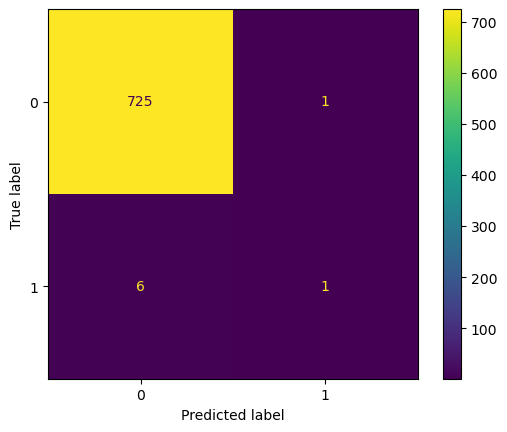

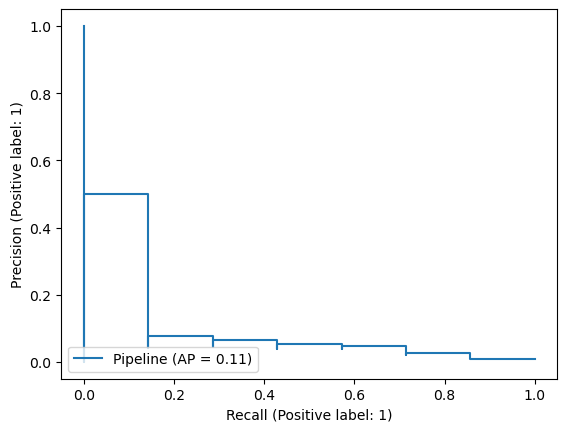

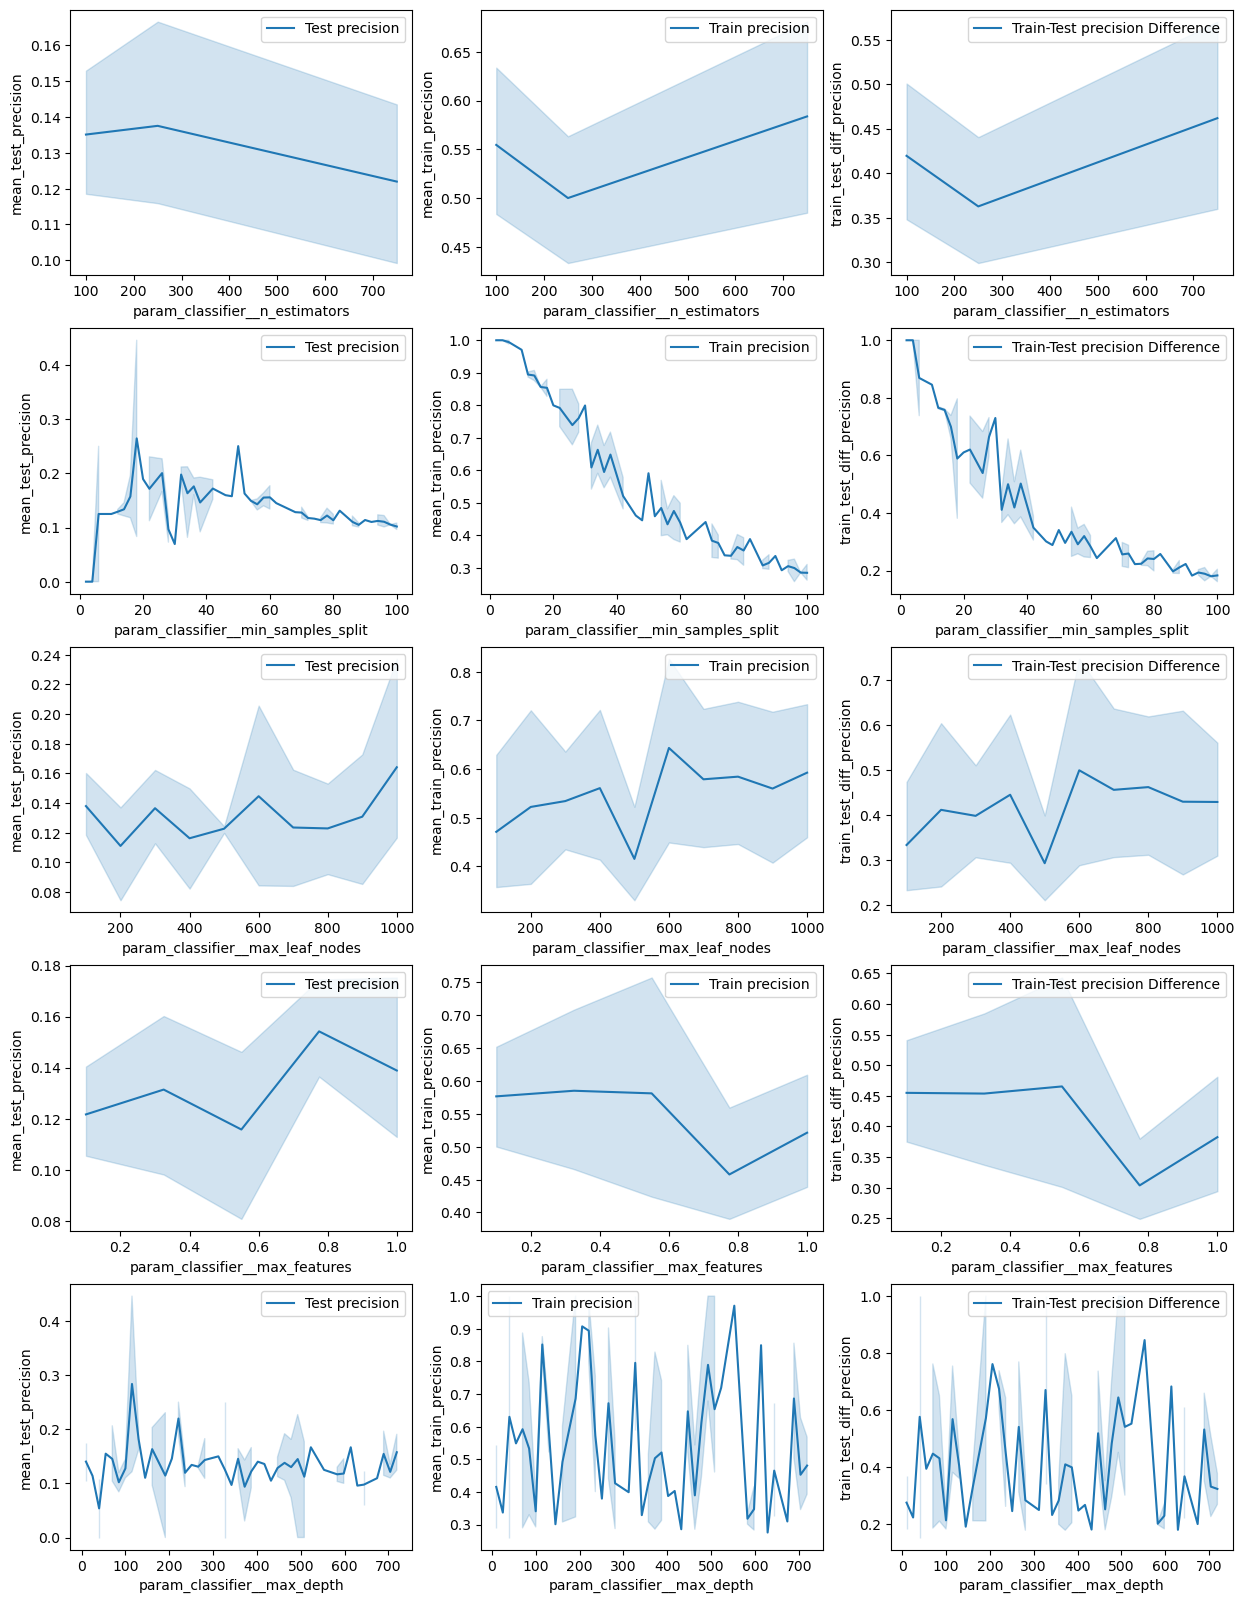

In [ ]:
param_distributions = {
        "classifier__min_samples_split": [int(i) for i in np.linspace(2, 100, 50)],
        "classifier__max_features": [i for i in np.linspace(0.1, 1, 5)],
        "classifier__max_depth": [int(i) for i in np.linspace(10, 750, 50)] + [None],
        "classifier__max_leaf_nodes": [int(i) for i in np.linspace(100, 1000, 10)] + [None]
    }

classifier = RandomForestClassifier(class_weight='balanced', n_estimators=250)
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('classifier', classifier)
    ])
random_search = run_experiment(features, param_distributions, pipeline, 
                               n_iter=100, n_splits=4, 
                               classifier=classifier)

final model

0.5


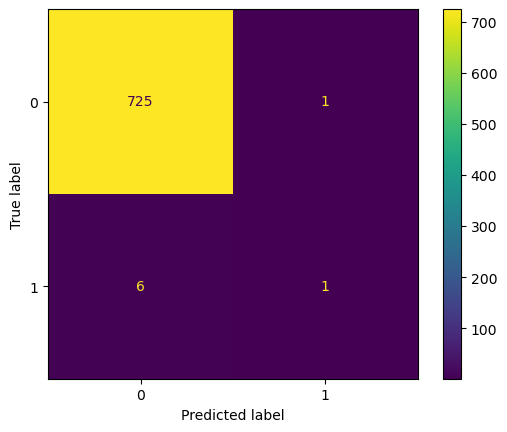

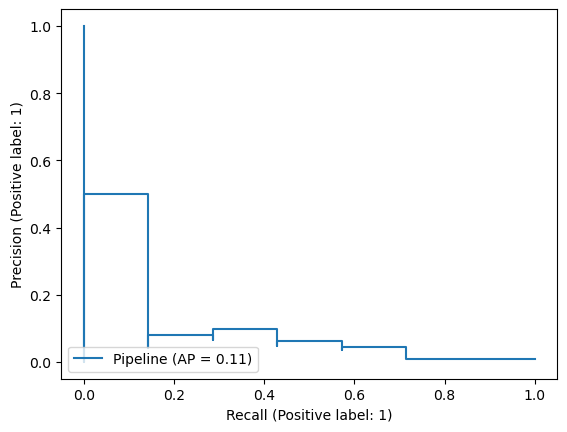

In [93]:
min_samples_split = 18
max_features = 1.0
max_depth = 115
max_leaf_nodes = 1000
bootstrap = True
n_estimators = 250

classifier = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split,
                                    max_features=max_features, max_depth=max_depth,
                                    max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap,
                                    class_weight='balanced')
pipeline = Pipeline([
        ('custom_preprocessor', CustomPreprocessor()),
        ('classifier', classifier)
    ])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
print(precision_score(y_test, y_pred))

PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test)
plt.show()

0.5


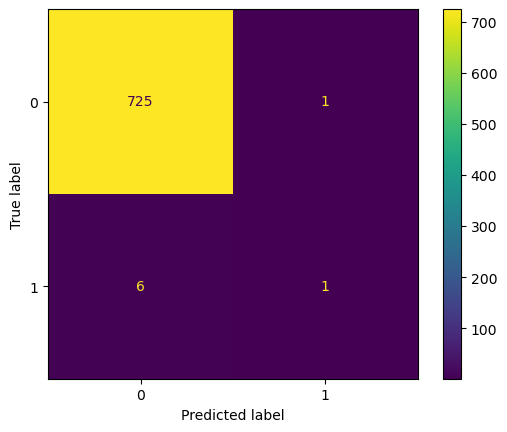

In [94]:
threshold = 0.5
y_pred = pipeline.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred > threshold, 1, 0)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()
print(precision_score(y_test, y_pred))

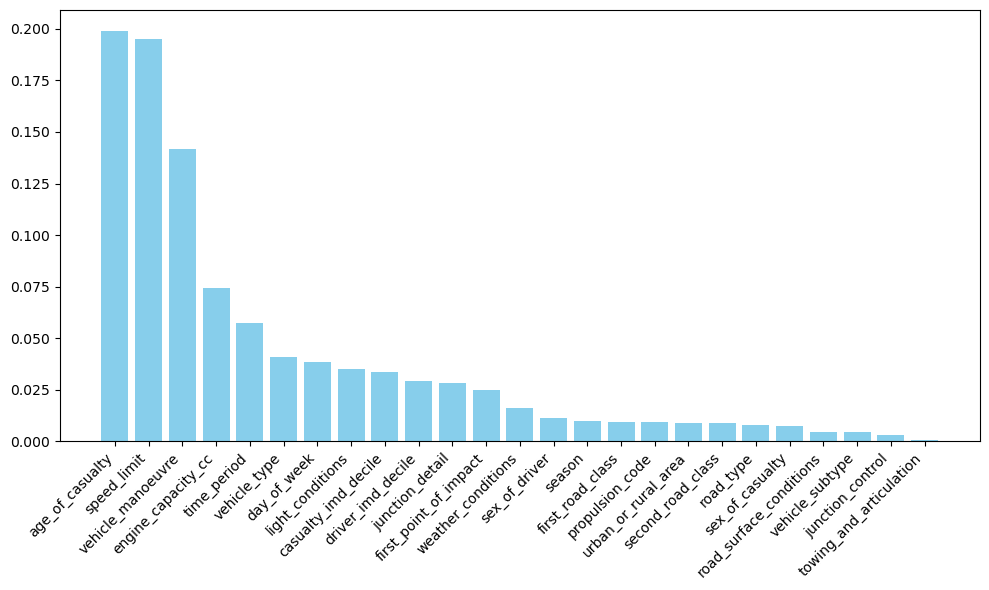

In [95]:
features = pipeline.named_steps["custom_preprocessor"].get_feature_names_out()
importances = pipeline.named_steps["classifier"].feature_importances_
feature_importances = sorted(
    [i for i in zip(features, importances)], 
    key=lambda x: x[1],
    reverse=True
)
feature_importances = feature_importances
labels, values = zip(*feature_importances)

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()